In [ ]:
!mkdir -p ../data
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz -P ../data
!tar xzf ../data/food-101.tar.gz -C ../data

--2020-12-24 15:46:41--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2020-12-24 15:46:41--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘../data/food-101.tar.gz’

food-101.tar.gz       1%[                    ]  55.76M  14.9MB/s    eta 6m 33s ^C

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r  "/content/drive/MyDrive/food_energy_detection/meta" ./meta
!tar -xf "/content/drive/MyDrive/food_energy_detection/food-110.tar.gz" -C /content/

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
# from imageio import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

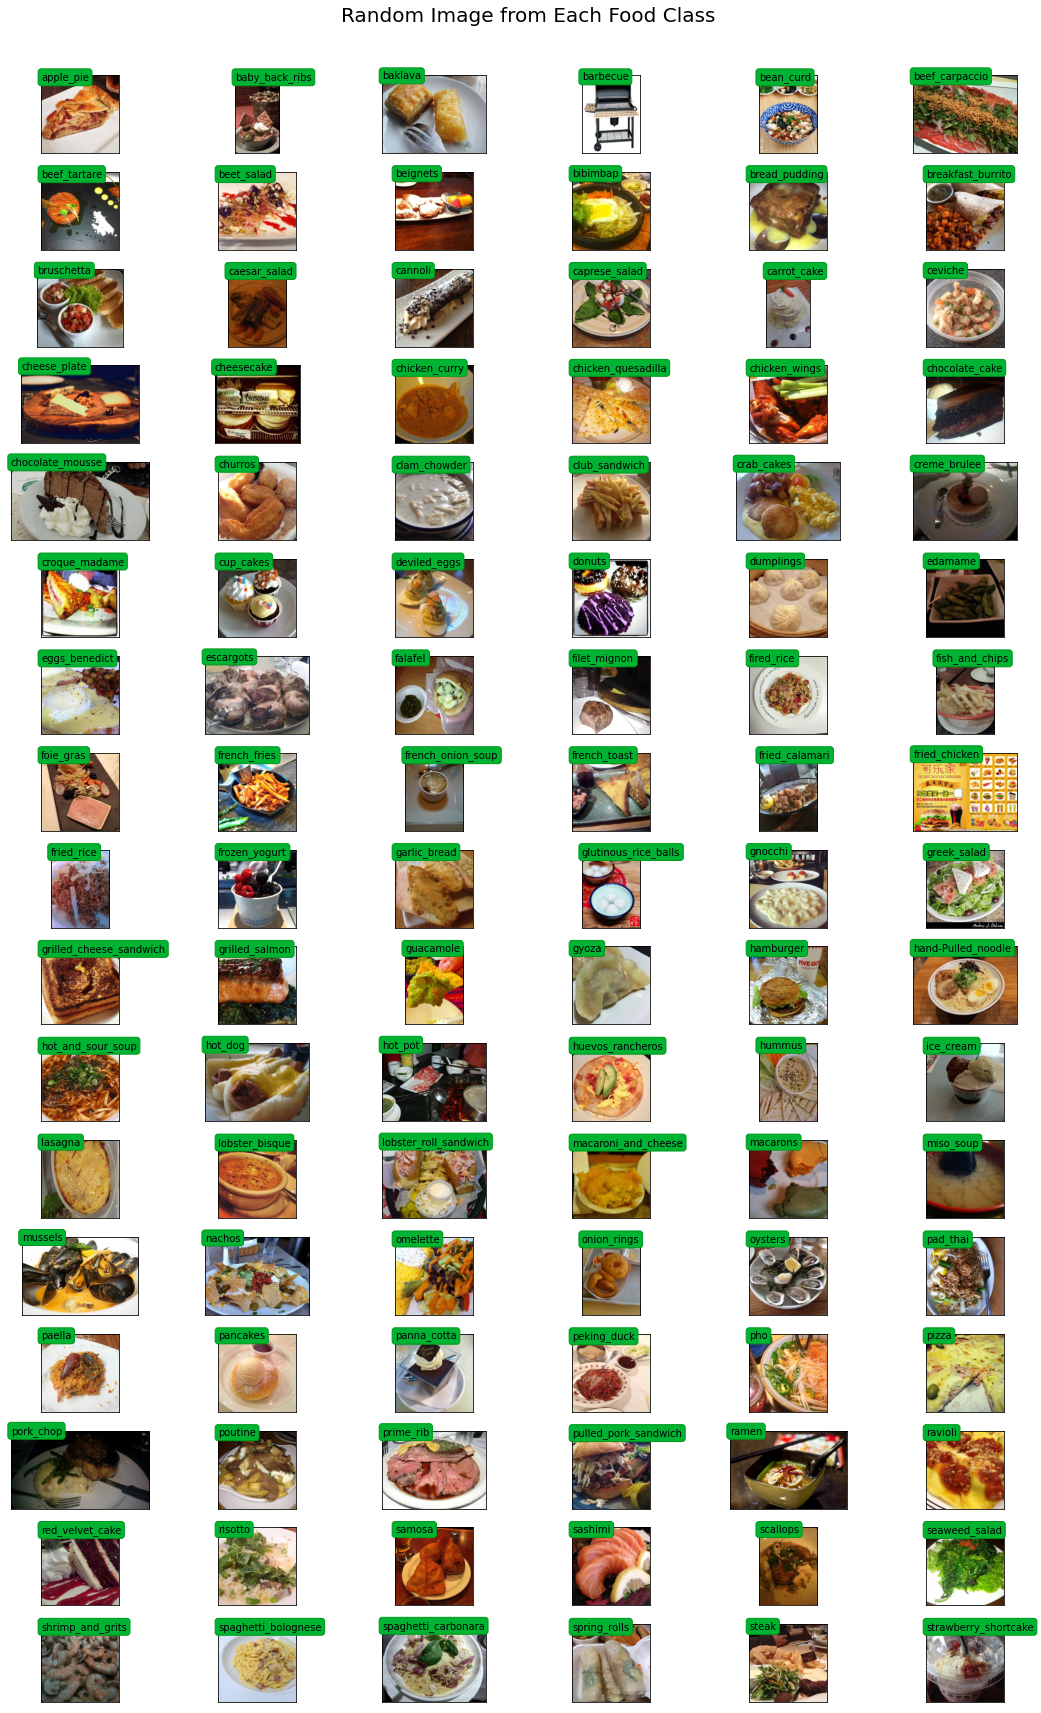

In [ ]:
root_dir = 'images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [1]:
%%capture
import os
from collections import defaultdict
import shutil, sys
import random
import math

In [2]:
!rm -r train
!rm -r test
train_root_dir = "train"
test_root_dir = "test"
if not os.path.exists(train_root_dir):
    os.makedirs(train_root_dir)
if not os.path.exists(test_root_dir):
    os.makedirs(test_root_dir)

for item in os.listdir("images"):
    train_path = os.path.join(train_root_dir, item)
    test_path = os.path.join(test_root_dir, item)
    if not os.path.exists(train_path):
        os.makedirs(train_path)
    if not os.path.exists(test_path):
        os.makedirs(test_path)

print(len(os.listdir(train_root_dir)))

valid_pct = 0.2
for item in os.listdir("images"):
    src = os.path.join("images", item)
    train_dft = os.path.join(train_root_dir, item)
    test_dft = os.path.join(test_root_dir, item)
    files = os.listdir(src)
    random.shuffle(files)
    valid_size = math.floor(valid_pct*len(files))
    test_files = files[0:valid_size]
    train_files = files[valid_size:]
    
    for train_file in train_files:
        shutil.copyfile(os.path.join(src, train_file), os.path.join(train_dft, train_file))
    for test_file in test_files:
        shutil.copyfile(os.path.join(src, test_file), os.path.join(test_dft, test_file))

rm: cannot remove 'train': No such file or directory
rm: cannot remove 'test': No such file or directory


FileNotFoundError: ignored

In [ ]:
from __future__ import print_function
from __future__ import division

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model
from keras.layers import Dense
from keras.layers import Input
import numpy as np
import argparse

In [ ]:
def setup_generator(train_path, test_path, batch_size, dimentions):
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1. / 255)

    train_generator = train_datagen.flow_from_directory(
        train_path,  # this is the target directory
        target_size=dimentions,
        batch_size=batch_size)

    validation_generator = test_datagen.flow_from_directory(
        test_path, # this is the target directory
        target_size=dimentions,
        batch_size=batch_size)

    return train_generator, validation_generator

In [ ]:
def load_image(img_path, dimentions, rescale=1./255):
    img = img.load_img(img_path, target_size=dimentions)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x *= rescale

    return x

In [ ]:
input_shape = (224, 224, 3)
X_train, X_test = setup_generator("train", "test", 64, shape[:2])
num_classes = X_train.num_classes
print(num_classes)

Found 26370 images belonging to 110 classes.
Found 6586 images belonging to 110 classes.
110


In [ ]:
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Dropout
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, Flatten
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.regularizers import l2
import keras.optimizers as optimizers
from keras.activations import relu
import keras.backend as K
import math

In [ ]:
def conv_block(layer, filters, kernel_size=(3, 3), strides=(1, 1), padding='valid', l2_reg=0.0, name=None):
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=strides,
               padding=padding,
               kernel_regularizer=l2(l2_reg),
               kernel_initializer="he_normal",
               name=name)(layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
def MyNet(input_shape=(224, 224, 3), num_classes=110, l2_reg=0.0, weights=None):
    """
    :param input_shape: input shape
    :param num_classes: the number of classes
    :param l2_reg:
    :param weights:
    :return: model
    """
    input_layer = Input(shape=input_shape)

    # Layer 1
    # In order to get the same size of the paper mentioned, add padding layer first
    x = ZeroPadding2D(padding=(2, 2))(input_layer)
    x = conv_block(x, filters=96, kernel_size=(11, 11),
                   strides=(4, 4), padding="valid", l2_reg=l2_reg, name='Conv_1_96_11x11_4')
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid", name="maxpool_1_3x3_2")(x)

    # Layer 2
    x = conv_block(x, filters=256, kernel_size=(5, 5),
                   strides=(1, 1), padding="same", l2_reg=l2_reg, name="Conv_2_256_5x5_1")
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid", name="maxpool_2_3x3_2")(x)

    # Layer 3
    x = conv_block(x, filters=384, kernel_size=(3, 3),
                   strides=(1, 1), padding="same", l2_reg=l2_reg, name="Conv_3_384_3x3_1")

    # Layer 4
    x = conv_block(x, filters=384, kernel_size=(3, 3),
                   strides=(1, 1), padding="same", l2_reg=l2_reg, name="Conv_4_384_3x3_1")

    # Layer 5
    x = conv_block(x, filters=256, kernel_size=(3, 3),
                   strides=(1, 1), padding="same", l2_reg=l2_reg, name="Conv_5_256_3x3_1")
    x = MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding="valid", name="maxpool_3_3x3_2")(x)

    # Layer 6
    x = Flatten()(x)
    x = Dense(units=4096)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dropout(0.5)(x)
    
    # Layer 7
    x = Dense(units=4096)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dropout(0.5)(x)

    # Layer 8
    x = Dense(units=1000)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dropout(0.5)(x)

    # Layer 9
    x = Dense(units=num_classes)(x)
    x = BatchNormalization()(x)
    x = Activation("softmax")(x)

    if weights is not None:
        x.load_weights(weights)
    model = Model(input_layer, x, name="MyNet")
    return model

In [ ]:
model = MyNet(input_shape=input_shape, num_classes=num_classes)
model.summary()

Model: "MyNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
Conv_1_96_11x11_4 (Conv2D)   (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization_22 (Batc (None, 55, 55, 96)        384       
_________________________________________________________________
activation_1 (Activation)    (None, 55, 55, 96)        0         
_________________________________________________________________
maxpool_1_3x3_2 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
Conv_2_256_5x5_1 (Conv2D)    (None, 27, 27, 256)       614656

In [ ]:
opt = SGD(lr=.1, momentum=.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/model4_lan2.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('/content/drive/My Drive/model4.log')

In [ ]:
def schedule(epoch):
    if epoch < 5:
        return 0.001
    elif epoch < 10:
        return .0002
    elif epoch < 15:
        return 0.00002
    else:
        return .0000005
lr_scheduler = LearningRateScheduler(schedule)

In [ ]:
model.fit_generator(X_train, validation_data=X_test,
                              epochs=15,
                              steps_per_epoch=X_train.samples//32,
                              validation_steps=X_test.samples//32,
                               callbacks=[lr_scheduler, csv_logger, checkpointer])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
  4/824 [..............................] - ETA: 2:01:18 - loss: 5.2704 - accuracy: 0.0146

KeyboardInterrupt: ignored